# Classification

In [577]:
# Import Packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Extra
from textblob import TextBlob
from langdetect import detect
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_with_no_labels.csv')

In [3]:
# Few rows of the data in the train set
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
train.shape

(15819, 3)

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15649 entries, 0 to 15818
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15649 non-null  int64 
 1   message    15649 non-null  object
 2   tweetid    15649 non-null  int64 
 3   language   15649 non-null  object
dtypes: int64(2), object(2)
memory usage: 611.3+ KB


In [4]:
# Checking the count of sentiments
count = train['sentiment'].value_counts()
count

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

<BarContainer object of 4 artists>

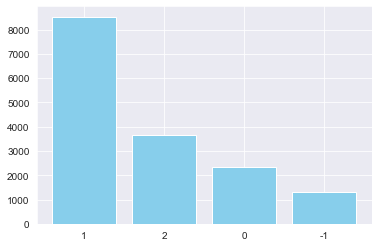

In [5]:
sns.set_style('darkgrid')
plt.bar(['1', '2', '0', '-1'], count, color = 'skyblue')

## Pre-processing

### Removing noise

In [411]:
print(f'The number of rows with links --> {len(train[train["message"].str.contains("http")]["message"])} rows')

The number of rows with links --> 8764 rows


Change all url links to the word `link`

In [162]:
def change_links(df, column):
    regex_pattern = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    url_ = r'link'
    df[column] = df[column].replace(to_replace = regex_pattern, 
                                    value = url_, 
                                    regex = True)

In [6]:
change_links(train, 'message')

### Language Check

In [7]:
def lang_check(post):
    lang = detect(post)
    return lang

In [8]:
train['language'] = train['message'].apply(lang_check)

In [9]:
train.head()

,sentiment,message,tweetid,language
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,en
1,1,It's not like we lack evidence of anthropogeni...,126103,en
2,2,RT @RawStory: Researchers say we have three ye...,698562,en
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,en
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,en


In [10]:
train = train[train['language'] == 'en']

In [12]:
train.shape

(15649, 4)

## Remove Stop words

In [66]:
train['message'] = train['message'].str.lower()

In [165]:
stop = stopwords.words('english')

In [68]:
def stop_words(post):
    post = ' '.join([word for word in post.split() if word not in stop])
    return post

In [69]:
train['message'] = train['message'].apply(stop_words)

## Remove Punctuations

In [169]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [170]:
def remove_punctuation(post):
    post = ''.join([x for x in post if x not in string.punctuation])
    return post

In [19]:
train['message'] = train['message'].apply(remove_punctuation)

### Spelling Check

In [426]:
# def spell_check(post):
#     blob = TextBlob(post)
#     post = str(blob.correct())
#     return post

## Lemmatization

In [172]:
lemmatizer = WordNetLemmatizer()

In [173]:
def lemmatize_(post):
    row = []
    for word in post.split():
        lem = lemmatizer.lemmatize(word)
        row.append(lem)
    post_ = ' '.join(row)
    return post_

In [22]:
train['message'] = train['message'].apply(lemmatize_)

### Check if rows contain words in vocabulary

In [176]:
vocab = words.words()

In [177]:
def word_check(post):
    checked = ' '.join([word for word in post.split() if word in vocab])
    return checked

In [83]:
train['message'] = train['message'].apply(word_check)

### Handling the imbalanced data

Firstly, we group the 4 classes into 2 discrete classes, 0 and 1.

In [45]:
train['sentiment'] = train['sentiment'].replace(-1, 0)

In [46]:
train['sentiment'] = train['sentiment'].replace(2, 1)

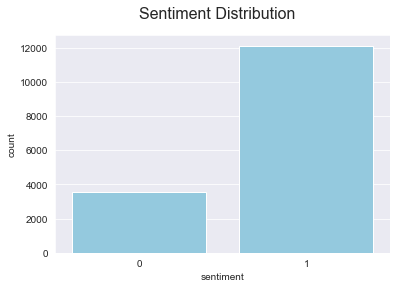

In [47]:
sns.set_style('darkgrid')
sns.countplot(x = train['sentiment'], data = train, color = 'skyblue')
plt.suptitle('Sentiment Distribution', fontsize = 16)
plt.show()

In [122]:
words = []
for post in df_x['message']:
    for word in post.split():
        words.append(word)
text = ' '.join(words)

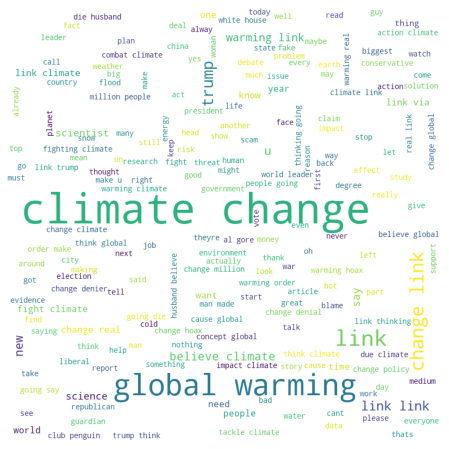

In [123]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Vectorize

In [632]:
vect = CountVectorizer(ngram_range = (1, 1), min_df = 0.02)

In [633]:
X = vect.fit_transform(train['message'])

In [634]:
df = pd.DataFrame(data = X.toarray(), columns = vect.get_feature_names())
df

,believe,change,climate,denier,die,fight,global,going,hoax,husband,...,science,scientist,think,thinking,trump,via,want,warming,world,year
0,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15644,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15645,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15646,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
15647,0,1,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [635]:
scaler = StandardScaler()

In [636]:
X = scaler.fit_transform(df)
y = train['sentiment']

In [637]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, random_state = 42)

#### Resampling
-----------

#### Random Forest
-------------

In [641]:
rf = RandomForestClassifier()

In [663]:
rf_param = {'n_estimators': [700, 800, 900], 
            'max_depth': [55, 60, 65], 
            'min_samples_leaf': [100, 200]}

In [664]:
cv = GridSearchCV(rf, 
                  param_grid = rf_param, 
                  scoring = 'f1', 
                  cv = 10)

In [665]:
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [55, 60, 65],
                         'min_samples_leaf': [100, 200],
                         'n_estimators': [700, 800, 900]},
             scoring='f1')

In [666]:
cv.best_params_

{'max_depth': 55, 'min_samples_leaf': 100, 'n_estimators': 700}

In [667]:
cv.best_score_

0.8726105231546095

In [668]:
y_pred = cv.predict(X_test)

In [669]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.85      1.00      0.92        17

    accuracy                           0.85        20
   macro avg       0.42      0.50      0.46        20
weighted avg       0.72      0.85      0.78        20



C:\Users\Morgan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Morgan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Morgan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [659]:
print(confusion_matrix(y_test, y_pred))

[[ 2  1]
 [ 1 16]]


#### KNeighbors
-----------

In [587]:
neigh = KNeighborsClassifier()

In [605]:
knn = GridSearchCV(neigh, 
                   param_grid = {'n_neighbors': [60, 65, 70], 
                                 'leaf_size': [30, 50, 55]}, 
                   scoring = 'f1', 
                   cv = 10)

In [606]:
knn.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [30, 50, 55],
                         'n_neighbors': [60, 65, 70]},
             scoring='f1')

In [607]:
knn.best_params_

{'leaf_size': 30, 'n_neighbors': 60}

In [608]:
knn.best_score_

0.8748563297364516

In [603]:
y_p = knn.predict(X_test)

In [604]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.89      0.94      0.91        17

    accuracy                           0.85        20
   macro avg       0.69      0.64      0.66        20
weighted avg       0.83      0.85      0.84        20



In [596]:
print(confusion_matrix(y_test, y_p))

[[ 1  2]
 [ 1 16]]


## Test set Deployment

In [163]:
change_links(test, 'message')

In [164]:
test['message'] = test['message'].str.lower()

In [166]:
test['message'] = test['message'].apply(stop_words)

In [174]:
test['message'] = test['message'].apply(remove_punctuation)

In [175]:
test['message'] = test['message'].apply(lemmatize_)

In [179]:
test['message'] = test['message'].apply(word_check)

In [638]:
vect_test = CountVectorizer(ngram_range = (1, 1), min_df = 0.01)

In [639]:
X_test_set = vect_test.fit_transform(test['message'])

In [640]:
pd.DataFrame(data = X_test_set.toarray(), columns = vect.get_feature_names())

ValueError: Shape of passed values is (10546, 94), indices imply (10546, 31)

In [621]:
y_pred_ = cv.predict(X_test_set)

In [622]:
submission = pd.DataFrame({'tweetid': test['tweetid'], 
                           'sentiment': y_pred_})

In [624]:
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [625]:
submission.to_csv('submission.csv', index = False)